In [1]:
import pandas as pd

predictions = pd.read_csv('predictions.csv', 
                          engine='c', 
                          low_memory=False, 
                          memory_map=True)
predictions.head()

,fname,label,score
0,clip_227de25a2.wav,off,0.689774
1,clip_5be3c9a8e.wav,_unknown_,0.978180
2,clip_642304206.wav,_unknown_,0.979443
3,clip_16270b7c9.wav,_silence_,0.997922
4,clip_daf840327.wav,stop,1.000000


In [2]:
predictions.count()

fname    158538
label    158538
score    158538
dtype: int64

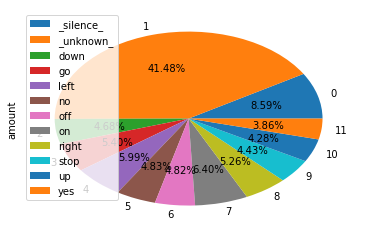

In [3]:
%matplotlib inline

from pandasql import sqldf
import matplotlib.pyplot as plt

pysqldf = lambda q: sqldf(q, globals())

label_counts = pysqldf("SELECT label, COUNT(label) AS amount FROM predictions GROUP BY label")
label_counts.plot(x='label', y='amount', kind='pie', legend=True, autopct='%1.2f%%')
plt.legend(labels=label_counts.label, loc="best")

Listen to some sample clips...

In [4]:
least_confident_predictions = pysqldf("SELECT * FROM predictions ORDER BY score ASC")
least_confident_predictions.head()

,fname,label,score
0,clip_5f3d7bdc8.wav,on,0.112524
1,clip_1fba3916c.wav,stop,0.112750
2,clip_b68eeee7d.wav,down,0.113297
3,clip_ede160141.wav,yes,0.114231
4,clip_fc776232c.wav,off,0.114688


In [5]:
import IPython.display as ipd
from scipy.io import wavfile

test_path = 'data/test/audio'
sample_rate, wav_file_data = wavfile.read(test_path + '/' + least_confident_predictions['fname'][0])

In [6]:
ipd.Audio(wav_file_data, rate=sample_rate)

# Distribution of Prediction Confidence

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f18b9be22e8>], dtype=object)

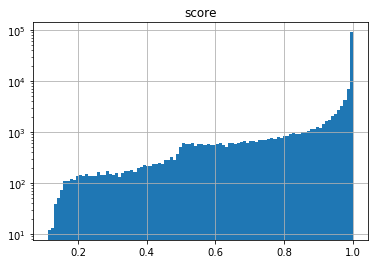

In [7]:
fig, ax = plt.subplots()
ax.set_yscale('log')
predictions.hist(ax=ax, column='score', bins=100)

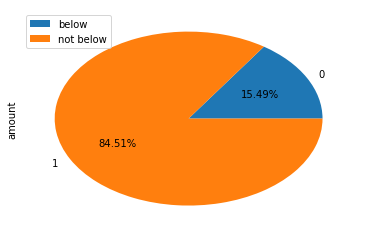

In [8]:
confidence_threshold_counts = pysqldf("SELECT CASE WHEN score < 0.75 THEN 'below' ELSE 'not below' END AS threshold, COUNT(*) AS amount FROM least_confident_predictions GROUP BY threshold")
confidence_threshold_counts.plot(x='threshold', y='amount', kind='pie', legend=True, autopct='%1.2f%%')
plt.legend(labels=confidence_threshold_counts.threshold, loc="best")

# Save to CSV

In [9]:
submission_sql_string = """
SELECT fname,
       CASE WHEN label = '_unknown_' THEN 'unknown'
            WHEN label = '_silence_' THEN 'silence'
            ELSE label 
        END AS label
  FROM predictions
"""
submission = pysqldf(submission_sql_string)

Check for unexpected labels...

In [10]:
unexpected_labels_sql_string = """
SELECT * 
  FROM submission
 WHERE label NOT IN ('unknown', 
                     'silence', 
                     'yes', 
                     'no', 
                     'up', 
                     'down', 
                     'left', 
                     'right', 
                     'on', 
                     'off', 
                     'stop', 
                     'go')
"""
pysqldf(unexpected_labels_sql_string).head()

,fname,label


In [11]:
submission.to_csv('submission.csv', index=False)